In [1]:
import os
import numpy as np 
import pandas as pd 
import random
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, preprocessing, layers, callbacks, optimizers
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
#görüntülerin olduğu klasör
img_dir = "images/"
#csv dosyamdan artist adı ve yaptığı tablo sayısı detaylarını okuma
label_df = pd.read_csv("artists.csv")
#görüntülerin isimlerinden sınıflara ayırma işlemi
classes = os.listdir(img_dir)

[]

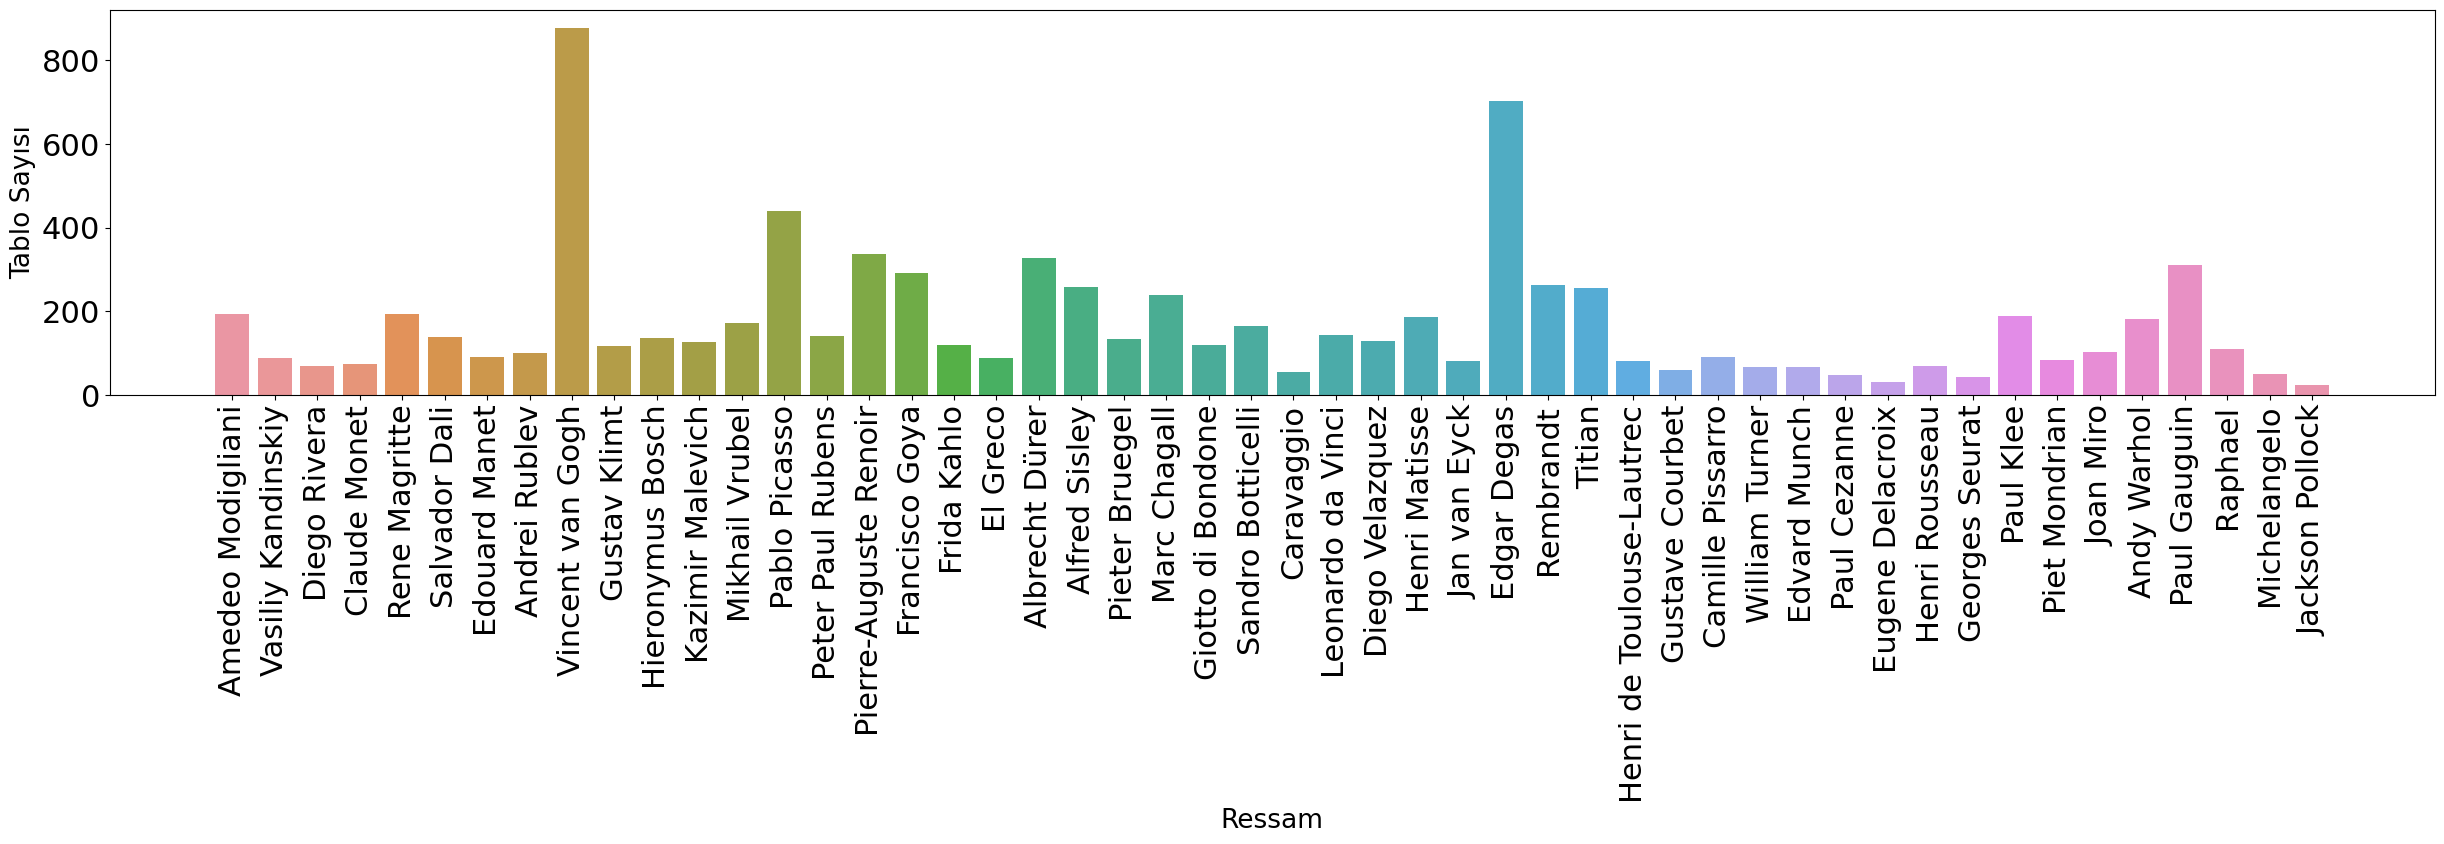

In [3]:
#sınıf (ressam isimlerinden) dataframe oluşturma
df = label_df


ylabel = "Tablo Sayısı"

params = {'figure.figsize' : (30, 5),'axes.labelsize' : 19,'axes.titlesize' : 22,'xtick.labelsize': 22,'ytick.labelsize': 22}

plt.rcParams.update(params)

sns.barplot(x="name", y="paintings", data=df)
plt.ylabel("Tablo Sayısı")
plt.xlabel("Ressam")

plt.xticks(rotation=90)
plt.plot()

In [4]:
#kaç adet sınıfım olduğunu ayarlıyorum, yani kaç ressam olduğu aslında
CLASSES = os.listdir(img_dir)
NUM_CLASSES = len(CLASSES)


# Sınıf ağırlıklarının hesaplanması, yani ressamların sonra bunları numoy dizisine dönüştürüp saklıyorum ileride lazım olacak
def get_weight(y, NUM_CLASSES):
    class_weights =  sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',classes= np.unique(y),y= y)
    return dict(enumerate(class_weights))

#Eğitim datasının önişlenmesi adımı.
train_datagen = preprocessing.image.ImageDataGenerator(
    #rescale ile görüntü oranı(tam emin değilim türkçesi ne olur) 0 ile 1 arasında bi yere sıkıştırılıyor.
    rescale=1.0/255,
    #dönddürme işlemleri
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    #görüntülerin %20'sini ayırdım keras ile 
    validation_split=0.2)


#eğitim datalarını oluşturmak yukarda %80'ini ayırmıştım ön işlemesini yaptım ve şimdi eğitim için hazırlıyorum
train_generator = train_datagen.flow_from_directory( 
    #görüntüleri alacağı yer
    img_dir,
    #girdi boyutu standart 224x224 olmalı
    target_size=(224,224),
    #kaç sınıfımın olduğu üstte tanımlı
    classes=CLASSES,
    class_mode="categorical",
    #aynı anda ağ üzerinden kaç verinin yürütüleceği batch_size 64 
    batch_size=64, 
    shuffle=True, 
    #rasgele bilgisi 42 random_state aslında
    seed=42,
    #subset olarak training veriyorum ki keras burayı training datası olarak ayırsın
    subset='training')


#test datalarını oluşturma
validation_generator = train_datagen.flow_from_directory(
    img_dir,
    classes=CLASSES,
    target_size=(224,224), 
    class_mode="categorical", 
    batch_size=64, 
    shuffle=False, 
    seed=42,
    #subset olarak validation veriyorum ki keras burayı test datası olarak ayırsın
    subset='validation')



class_weights = get_weight(train_generator.classes, NUM_CLASSES)

steps_per_epoch = len(train_generator)

validation_steps = len(validation_generator)


Found 6516 images belonging to 49 classes.
Found 1602 images belonging to 49 classes.


In [5]:
#girdilerin standart boyutunu belirliyorum
INPUT_SHAPE = (224, 224, 3)

#görüntü ağırlıkları olarak standart haline gelen imagenet kullanıyorum
weights = 'imagenet'

#görüntü girdileri 224x224x3 olarak veriyorum. Bu da bir standart
inputs = layers.Input(INPUT_SHAPE)

#kullanacağım modelin inception ağı olduğunu belirtiyorum
base_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights=weights,
    input_shape=INPUT_SHAPE,
)
            
#ağa ekstra katmanlar ekliyorum normalizsayonu batch tipinden 
#0.5 oranında çıkışlara rasgele 0 değer atıyorum ki aşırı öğrenmenin önüne geçeyim bunu 3 kez yapıyorum.
#arada 512 nöronlu bir kat ekliyorum ve aktivasyonunu relu belirliyorum.
#görüntü işleme problemlerinde standart haline gelmiş softmax katmanını da yine en sona ekliyorum ki ağdan çıkıştaki sonuçlardan
#en yüksek değerlikli olana 0 ve 1 aralığından direkt 1 verilip sonuç kesinleştirilsin. Kazanan her şeyi alır mantığı.
x = base_model.output
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Dropout(0.5)(x)

#hazır ağdan çıkınca kod benim eklediğim kısıma girsin diye bu işlemi yapıyorum
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

#burada hazır ağ ve benim yazdığım kısmın arka arkaya çalışmasını sağlıyorum.
model = keras.Model(inputs=base_model.input, outputs=outputs)


In [6]:
#Bir metriğin gelişimi durursa öğrenme oranını artırıyorum ki model öğrenmeye devam etsin
reduce_lr = callbacks.ReduceLROnPlateau(
    #izlenecek veri val_loss
    monitor='val_loss',
    #ne kadar azalacağı
    factor=0.1,
    #5 kez oranda artış olmazsa işleme öprenme oranını düşürüyor
    patience=5,
    mode='auto',
    verbose=1)

#modelimi compile ediyorum derliyorum yeni eklediğim özelliklerle
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#ağırlıkları güncellemek için verdiğim döngü sayısı 10
#progress bar görmek istediğim için verbose 1 dedim
#callbacks dediğimse üstte belirlediğim callback fonksiyonu

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    verbose=1,
    callbacks=[reduce_lr],
    validation_data=validation_generator,
    validation_steps=validation_steps,
    class_weight=class_weights
)

C:\Users\berka\AppData\Local\Temp\ipykernel_16300\741653716.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
102/102 [==============================] - 678s 6s/step - loss: 4.2331 - accuracy: 0.0482 - val_loss: 3.3266 - val_accuracy: 0.1860 - lr: 1.0000e-04
Epoch 2/10
102/102 [==============================] - 643s 6s/step - loss: 3.1211 - accuracy: 0.1799 - val_loss: 2.6607 - val_accuracy: 0.3446 - lr: 1.0000e-04
Epoch 3/10
102/102 [==============================] - 631s 6s/step - loss: 2.3403 - accuracy: 0.3069 - val_loss: 2.2323 - val_accuracy: 0.4089 - lr: 1.0000e-04
Epoch 4/10
102/102 [==============================] - 649s 6s/step - loss: 1.7642 - accuracy: 0.4378 - val_loss: 1.9036 - val_accuracy: 0.4869 - lr: 1.0000e-04
Epoch 5/10
102/102 [==============================] - 657s 6s/step - loss: 1.3709 - accuracy: 0.5281 - val_loss: 1.7794 - val_accuracy: 0.5162 - lr: 1.0000e-04
Epoch 6/10
102/102 [==============================] - 658s 6s/step - loss: 1.0533 - accuracy: 0.6166 - val_loss: 1.6222 - val_accuracy: 0.5618 - lr: 1.0000e-04
Epoch 7/10
102/102 [====================

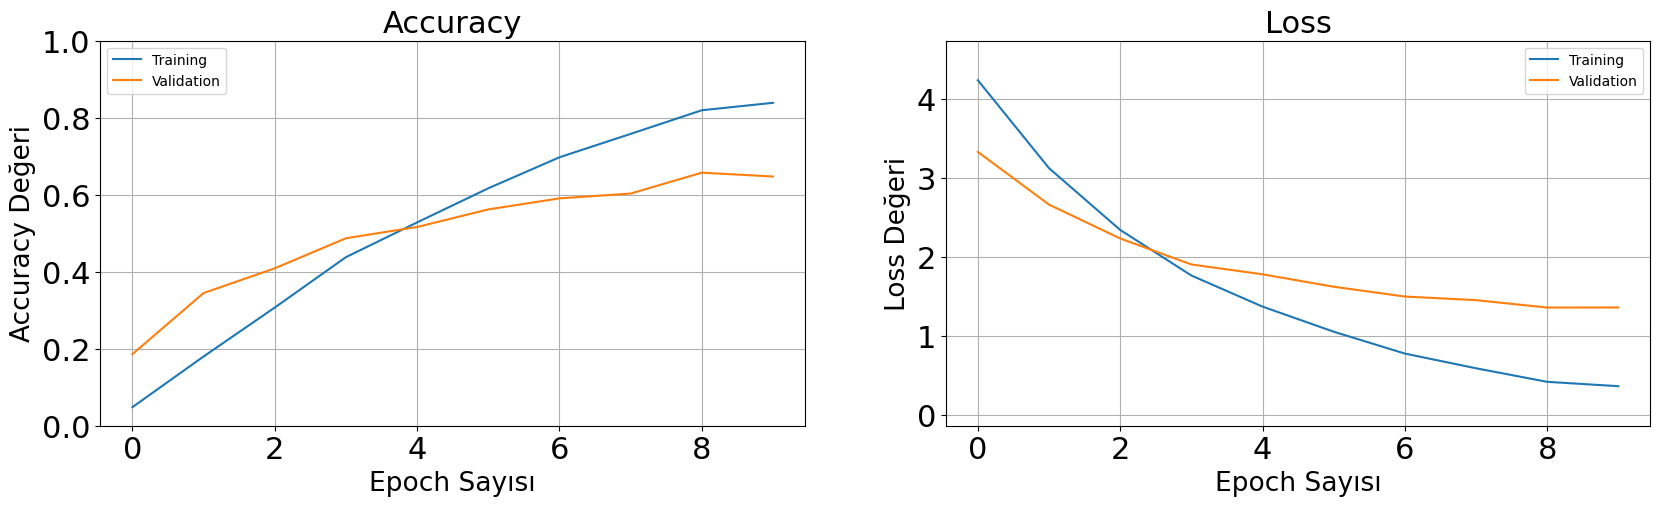

In [92]:
#grafiklerin labelları ve çizgilerin adı
xlabel = 'Epoch Sayısı'
legends = ['Training', 'Validation']


#grafik boyutu
plt.figure(figsize=(20, 5))

#accuacy ve val_accuracy değerlerini modelden alıp değişkenlere atıyorum
y1 = history.history['accuracy']
y2 = history.history['val_accuracy']

#min ve max gösterilen değerleri ayarlıyorum
min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]
    
min_y = 0
max_y = 1

#ikinci grafiği yerini ayarlamak
plt.subplot(121)
#grafiklere veri basmak

plt.plot(y1)
plt.plot(y2)
#grafik title ları ve labelları
plt.title('Accuracy')
plt.xlabel(xlabel)
plt.ylabel('Accuracy Değeri')
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

#bu sefer de loss ve val_loss değerlerini alıyorum
y1 = history.history['loss']
y2 = history.history['val_loss']
#aynı min max işlemini uyguluyorum
min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]

plt.subplot(122)
#grafiklerde gösteriyorum
plt.plot(y1)
plt.plot(y2)
#grafiklerin label ve title bilgisini ayarlama
plt.title('Loss')
plt.xlabel(xlabel)
plt.ylabel('Loss Değeri')
plt.ylim(min_y, max_y)
plt.legend(legends)
plt.grid()

#grafikleri gösterme
plt.show()

In [9]:
#keras ile oluşturduğum gerçek değerlerin etiketlerini y_trues isminde bir değişkene atıyorum
y_trues = validation_generator.labels
#modele tahmin yaptırıp değerleri y_preds ismindeki değişkende saklıyorum
y_preds = model.predict(validation_generator, verbose=1)
y_preds = y_preds.argmax(axis=1)

26/26 [==============================] - 52s 2s/step


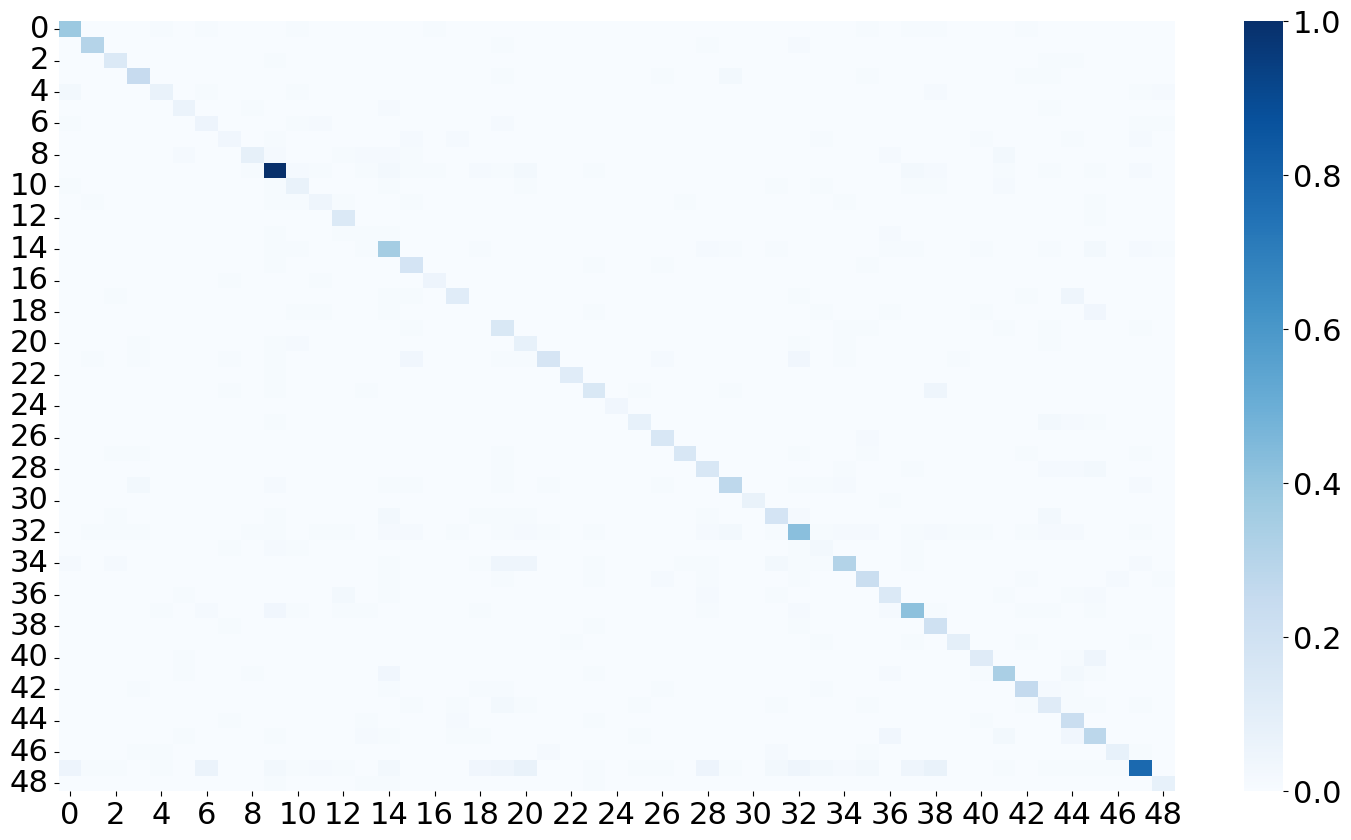

In [19]:
#karmaşıklık matrisini üstteki tahmin ve gerçeklik değerlerimle oluşturuyorum
matrix = metrics.confusion_matrix(y_trues, y_preds)
#grafik olarak ısı haritasıyla birlikte basıyorum. etiket bilgilerini alamadım bu sefer. diğer modellerimde var
plt.figure(figsize = (18,10))
sns.heatmap(matrix/np.max(matrix), cmap='Blues')
#grafiği bastırma
plt.show()

In [78]:
from sklearn.metrics import *
#üst tarafta gerçek ve tahmin değerlerini tutan değişkenlerimle bu kez metriklerimi basıyorum
print(classification_report(y_trues, y_preds))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80        51
           1       0.89      0.89      0.89        38
           2       0.70      0.84      0.76        19
           3       0.76      0.78      0.77        36
           4       0.67      0.44      0.53        18
           5       0.54      0.64      0.58        11
           6       0.35      0.43      0.39        14
           7       0.40      0.29      0.33        14
           8       0.71      0.40      0.51        25
           9       0.80      0.81      0.80       140
          10       0.38      0.44      0.41        18
          11       0.38      0.38      0.38        13
          12       0.64      0.94      0.76        17
          13       0.09      0.17      0.12         6
          14       0.57      0.69      0.62        58
          15       0.57      0.83      0.68        24
          16       0.75      0.75      0.75         8
          17       0.65    